In [2]:
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 51.9 MB/s eta 0:00:00


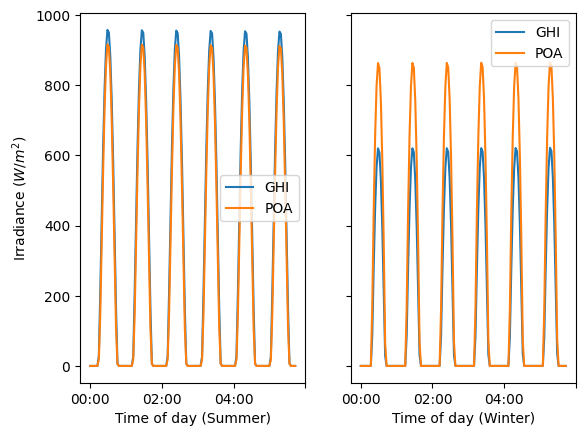

In [3]:
from pvlib import location
from pvlib import irradiance
import pandas as pd
from matplotlib import pyplot as plt

# For this example, we will be using Golden, Colorado
# tz = 'MST'
# lat, lon = 39.755, -105.221
# For this example, we will be using Kolkata, Asia
tz = 'Asia/Calcutta'
lat, lon = 28.6, 77.2

# Create location object to store lat, lon, timezone
site = location.Location(lat, lon, tz=tz)


# Calculate clear-sky GHI and transpose to plane of array
# Define a function so that we can re-use the sequence of operations with
# different locations
def get_irradiance(site_location, date, tilt, surface_azimuth):
    # Creates one day's worth of 10 min intervals
    times = pd.date_range(date, freq='60min', periods=6*24,
                          tz=site_location.tz)
    # Generate clearsky data using the Ineichen model, which is the default
    # The get_clearsky method returns a dataframe with values for GHI, DNI,
    # and DHI
    clearsky = site_location.get_clearsky(times)
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site_location.get_solarposition(times=times)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    # Return DataFrame with only GHI and POA
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})


# Get irradiance data for summer and winter solstice, assuming 25 degree tilt
# and a south facing array
summer_irradiance = get_irradiance(site, '06-20-2025', 25, 180)
winter_irradiance = get_irradiance(site, '12-21-2025', 25, 180)

# Convert Dataframe Indexes to Hour:Minute format to make plotting easier
summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")

# Plot GHI vs. POA for winter and summer
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
summer_irradiance['GHI'].plot(ax=ax1, label='GHI')
summer_irradiance['POA'].plot(ax=ax1, label='POA')
winter_irradiance['GHI'].plot(ax=ax2, label='GHI')
winter_irradiance['POA'].plot(ax=ax2, label='POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
plt.show()

<ipython-input-4-fcfc60d1bd39>:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range('2019-01-01 00:00:00', '2020-01-01', freq='H', tz=tz)


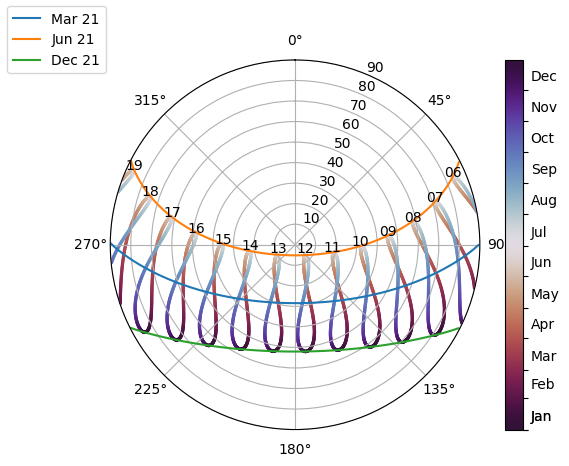

<ipython-input-4-fcfc60d1bd39>:115: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range('2019-01-01 00:00:00', '2020-01-01', freq='H', tz=tz)


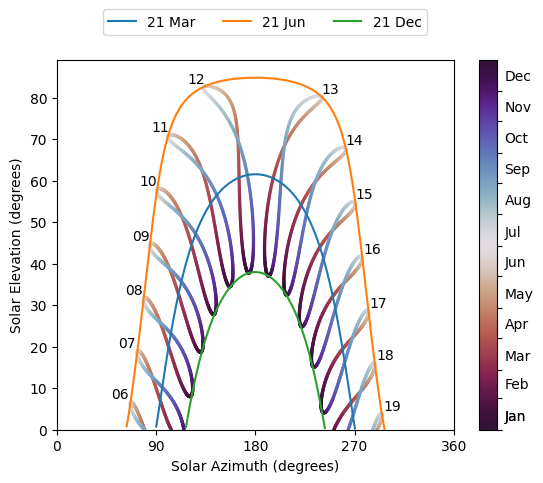

In [4]:
"""
Sun path diagram
================

Examples of generating sunpath diagrams.
"""

#%%
# This example shows basic usage of pvlib's solar position calculations with
# :py:meth:`pvlib.solarposition.get_solarposition`.  The examples shown here
# will generate sunpath diagrams that shows solar position over a year.
#
# Polar plot
# ----------
#
# Below is an example plot of solar position in
# `polar coordinates <https://en.wikipedia.org/wiki/Polar_coordinate_system>`_.

from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tz = 'Asia/Calcutta'
lat, lon = 28.6, 77.2

times = pd.date_range('2019-01-01 00:00:00', '2020-01-01', freq='H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

ax = plt.subplot(1, 1, 1, projection='polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear,
                    cmap='twilight_shifted_r')
# add and format colorbar
cbar = ax.figure.colorbar(points)
times_ticks = pd.date_range('2019-01-01', '2020-01-01', freq='MS', tz=tz)
cbar.set_ticks(ticks=times_ticks.dayofyear, labels=[], minor=False)
cbar.set_ticks(ticks=times_ticks.dayofyear+15,
               labels=times_ticks.strftime('%b'),
               minor=True)
cbar.ax.tick_params(which='minor', width=0)

# draw hour labels
for hour in np.unique(solpos.index.hour):
    # choose label position by the smallest radius for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'],
            str(hour).zfill(2), ha='center', va='bottom')

# draw individual days
for date in pd.to_datetime(['2019-03-21', '2019-06-21', '2019-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%b %d')
    ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)

ax.figure.legend(loc='upper left')

# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.show()

#%%
# This is a polar plot of hourly solar zenith and azimuth. The figure-8
# patterns are called `analemmas <https://en.wikipedia.org/wiki/Analemma>`_ and
# show how the sun's path slowly shifts over the course of the year .  The
# solid colored lines show the single-day sun paths for the winter and summer
# solstices as well as the spring equinox.
#
# The soltice paths mark the boundary of the sky area that the sun traverses
# over a year.  The diagram shows that there is no point in the
# year when is the sun directly overhead (zenith=0) -- note that this location
# is north of the Tropic of Cancer.
#
# Examining the sun path for the summer solstice in particular shows that
# the sun rises north of east, crosses into the southern sky around 10 AM for a
# few hours before crossing back into the northern sky around 3 PM and setting
# north of west.  In contrast, the winter solstice sun path remains in the
# southern sky the entire day.  Moreover, the diagram shows that the winter
# solstice is a shorter day than the summer soltice -- in December, the sun
# rises after 7 AM and sets before 6 PM, whereas in June the sun is up before
# 6 AM and sets after 7 PM.
#
# Another use of this diagram is to determine what times of year the sun is
# blocked by obstacles. For instance, for a mountain range on the western side
# of an array that extends 10 degrees above the horizon, the sun is blocked:
#
# - after about 6:30 PM on the summer solstice
# - after about 5:30 PM on the spring equinox
# - after about 4:30 PM on the winter solstice

#%%
# PVSyst Plot
# -----------
#
# PVSyst users will be more familiar with sunpath diagrams in Cartesian
# coordinates:

from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tz = 'Asia/Calcutta'
lat, lon = 28.6, 77.2
times = pd.date_range('2019-01-01 00:00:00', '2020-01-01', freq='H', tz=tz)

solpos = solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

fig, ax = plt.subplots()
points = ax.scatter(solpos.azimuth, solpos.apparent_elevation, s=2,
                    c=solpos.index.dayofyear, label=None,
                    cmap='twilight_shifted_r')
# add and format colorbar
cbar = fig.colorbar(points)
times_ticks = pd.date_range('2019-01-01', '2020-01-01', freq='MS', tz=tz)
cbar.set_ticks(ticks=times_ticks.dayofyear, labels=[], minor=False)
cbar.set_ticks(ticks=times_ticks.dayofyear+15,
               labels=times_ticks.strftime('%b'),
               minor=True)
cbar.ax.tick_params(which='minor', width=0)

for hour in np.unique(solpos.index.hour):
    # choose label position by the largest elevation for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    height = subset.apparent_elevation
    pos = solpos.loc[height.idxmax(), :]
    azimuth_offset = -10 if pos['azimuth'] < 180 else 10
    ax.text(pos['azimuth']+azimuth_offset, pos['apparent_elevation'],
            str(hour).zfill(2), ha='center', va='bottom')

for date in pd.to_datetime(['2019-03-21', '2019-06-21', '2019-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%d %b')
    ax.plot(solpos.azimuth, solpos.apparent_elevation, label=label)

ax.figure.legend(loc='upper center', bbox_to_anchor=[0.45, 1], ncols=3)
ax.set_xlabel('Solar Azimuth (degrees)')
ax.set_ylabel('Solar Elevation (degrees)')
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylim(0, None)

plt.show()